In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<h1> Loading a data frame with business ids and restrant labels

In [2]:
df_train_labels = pd.DataFrame.from_csv('train.csv')
df_train_labels.reset_index(level=0, inplace=True)
df_train_labels.head(5)

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8


In [3]:
df_common_labels = df_train_labels.groupby('labels').count().sort('business_id', ascending = False).head(10)

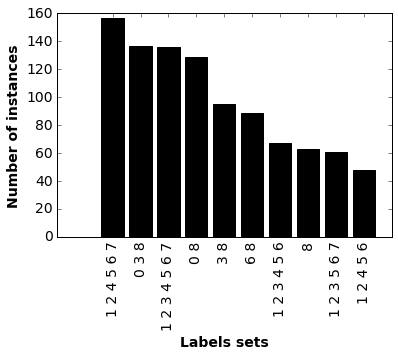

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)
plt.bar(range(len(df_common_labels)), np.array(df_common_labels.business_id), align='center', color = 'black')
plt.xticks(range(len(df_common_labels)), np.array(df_common_labels.index))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel('Number of instances', fontweight = 'bold')
plt.xlabel('Labels sets', fontweight = 'bold')


<h1> Loading mean CNN codes

<h2> Features used in classifying

In [5]:
def df_train_for_classifier(layer, df_train_labels):
    name_df = 'df_train_'+layer
    df = pd.read_pickle(name_df)
    df.reset_index(level=0, inplace=True)
    df = pd.merge(df, df_train_labels, on = 'business_id')
    df = df.dropna(how = 'any')
    df['meanCNN'] = df['meanCNN'].apply(lambda x: list(x))
    
    data = df['meanCNN']
    data = np.array([x for x in data])
    
    df['labels'] = df['labels'].apply(lambda x: map(float, x.split(' ')))
    labels = MultiLabelBinarizer().fit_transform(df['labels'])
    
    return data, labels, df['labels']

In [6]:
train_data_fc6, train_labels, train_labels_raw = df_train_for_classifier('fc6', df_train_labels)
train_data_fc7, _, _ = df_train_for_classifier('fc7', df_train_labels)
train_data_fc8, _, _ = df_train_for_classifier('fc8', df_train_labels)
train_data_prob, _, _ = df_train_for_classifier('prob', df_train_labels)

In [7]:
features_combinations = [train_data_fc6, train_data_fc7, train_data_fc8, train_data_prob, 
                         np.hstack((train_data_fc6, train_data_fc7)), np.hstack((train_data_fc7, train_data_fc8)),
                        np.hstack((train_data_fc8, train_data_prob)), np.hstack((train_data_fc6, train_data_fc8)),
                        np.hstack((train_data_fc6, train_data_prob)), np.hstack((train_data_fc7, train_data_prob)),
                        np.hstack((train_data_fc6, train_data_fc7, train_data_fc8)), 
                        np.hstack((train_data_fc7, train_data_fc8, train_data_prob)),
                        np.hstack((train_data_fc6, train_data_fc8, train_data_prob)),
                         np.hstack((train_data_fc6, train_data_fc7, train_data_prob)),
                        np.hstack((train_data_fc6, train_data_fc7, train_data_fc8, train_data_prob)),]

In [8]:
features_names = ['fc6', 'fc7', 'fc8', 'prob', 'fc6_fc7', 'fc7_fc8','fc8_prob', 'fc6_fc8',
                        'fc6_prob', 'fc7_prob','fc6_fc7_fc8','fc7_fc8_prob','fc6_fc8_prob',
                         'fc6_fc7_prob','fc6_fc7_fc8_prob']

In [9]:
features = dict(zip(features_names, features_combinations))

<h1> Training classifiers

In [185]:
##Cross-validation
kf = cross_validation.KFold(n = 1996, n_folds = 5)

<h2> Logistic Regression

<h3> Testing performance of PCA decomposition on features

In [186]:
def cv_pca_decomp(clf, data, labels, n_comp_ar):
    kf = cross_validation.KFold(n = 1996, n_folds = 5)
    meanscores_pca = []
    meanscore_def = np.mean(cross_validation.cross_val_score(clf, data, labels, cv = kf, scoring = 'f1'))
    
    for n in n_comp_ar:
        if data.shape[1] > n:
            data_reduced = PCA(n_components=n).fit_transform(data)
            score = np.mean(cross_validation.cross_val_score(clf, data_reduced, labels, cv = kf, scoring = 'f1'))
            meanscores_pca.append(score)
        else:
            meanscores_pca.append(np.nan)
    
    return meanscore_def, meanscores_pca

In [187]:
clf = OneVsRestClassifier(LogisticRegression())

In [188]:
n_comp_ar = [100, 250, 500, 1000, 2000]

In [189]:
cv_score_pca_log_reg = {}
for data, name in zip(features_combinations, features_names):
    print(name)
    clf = OneVsRestClassifier(LogisticRegression())
    meanscore_def, meanscores_pca = cv_pca_decomp(clf, data, train_labels, n_comp_ar)
    cv_score_pca_log_reg[name] = [meanscore_def, meanscores_pca]

fc6
fc7
fc8
prob
fc6_fc7
fc7_fc8
fc8_prob
fc6_fc8
fc6_prob
fc7_prob
fc6_fc7_fc8
fc7_fc8_prob
fc6_fc8_prob
fc6_fc7_prob
fc6_fc7_fc8_prob


In [190]:
df_cv_score_pca_log_reg = pd.DataFrame(cv_score_pca_log_reg)

In [191]:
#df_cv_score_pca_log_reg.to_pickle('df_cv_score_pca_log_reg')

In [192]:
df_cv_score_pca_log_reg = pd.read_pickle('df_cv_score_pca_log_reg')

In [193]:
df_cv_score_pca_log_reg = df_cv_score_pca_log_reg.append([df_cv_score_pca_log_reg.loc[1,]]*4)

In [194]:
df_cv_score_pca_log_reg = df_cv_score_pca_log_reg.set_index([['default','pca100','pca250','pca500','pca1000', 'pca2000']])

In [195]:
df_cv_score_pca_log_reg.loc['pca100',:] = df_cv_score_pca_log_reg.loc['pca100',:].apply(lambda x: x[0])
df_cv_score_pca_log_reg.loc['pca250',:] = df_cv_score_pca_log_reg.loc['pca250',:].apply(lambda x: x[1])
df_cv_score_pca_log_reg.loc['pca500',:] = df_cv_score_pca_log_reg.loc['pca500',:].apply(lambda x: x[2])
df_cv_score_pca_log_reg.loc['pca1000',:] = df_cv_score_pca_log_reg.loc['pca1000',:].apply(lambda x: x[3])
df_cv_score_pca_log_reg.loc['pca2000',:] = df_cv_score_pca_log_reg.loc['pca2000',:].apply(lambda x: x[4])

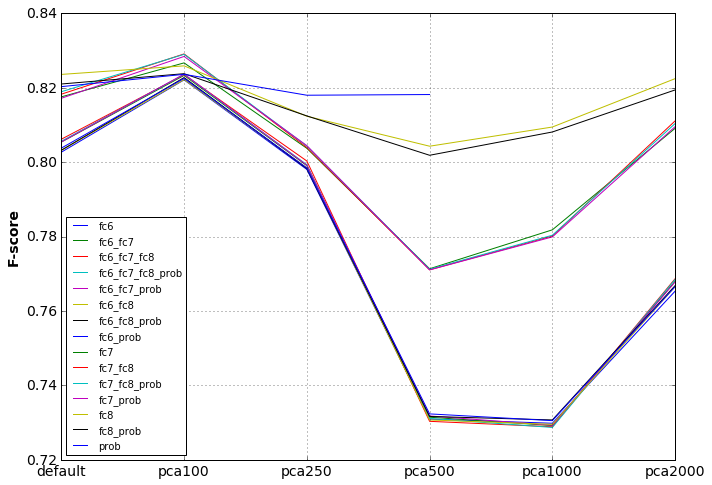

In [197]:
plt.figure(figsize = (11,8))
for c in df_cv_score_pca_log_reg.columns:
    plt.plot(np.arange(0, 6), np.array(df_cv_score_pca_log_reg[c]), label = c)
    
plt.legend(loc = 3, fontsize = 10)
plt.xticks(np.arange(0, 6),np.array(df_cv_score_pca_log_reg.index))
plt.grid()
plt.ylabel('F-score', fontweight = 'bold', fontsize = 14)
plt.savefig('test.jpg')

In [60]:
df_cv_score_pca_log_reg.idxmax()

fc6                 pca100
fc6_fc7             pca100
fc6_fc7_fc8         pca100
fc6_fc7_fc8_prob    pca100
fc6_fc7_prob        pca100
fc6_fc8             pca100
fc6_fc8_prob        pca100
fc6_prob            pca100
fc7                 pca100
fc7_fc8             pca100
fc7_fc8_prob        pca100
fc7_prob            pca100
fc8                 pca100
fc8_prob            pca100
prob                pca100
dtype: object

In [72]:
df_cv_score_pca_log_reg.loc['pca100',].sort(ascending=False, inplace=False)

C:\Users\asr1g12\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


fc7_fc8             0.829107
fc7_fc8_prob        0.828999
fc7_prob            0.828429
fc7                 0.826697
fc8                 0.825897
fc8_prob            0.823796
fc6_fc7_prob        0.823688
prob                0.823624
fc6_fc7_fc8_prob     0.82358
fc6_fc7_fc8         0.823484
fc6_fc7             0.823335
fc6_fc8_prob        0.822746
fc6_prob            0.822533
fc6_fc8             0.822197
fc6                 0.822139
Name: pca100, dtype: object

-----------------------------------------

PCA decomposition to 100 components shows the best result for the Logistic Regression classifier for all combinations of features. The best performing combination of features is outcome from layer fc7 concated with the outcome from layer fc8

In [8]:
train_data_reduced = PCA(n_components=100).fit_transform(features['fc7_fc8'])

<h3> Selecting the best parameters for Logistic regression classifier

In [162]:
param_grid_log_reg = {"estimator__C": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10,100],
                     "estimator__penalty": ['l1', 'l2']}

In [163]:
grid = GridSearchCV(OneVsRestClassifier(LogisticRegression()), param_grid_log_reg, scoring='f1')

In [164]:
grid = grid.fit(train_data_reduced, train_labels)

In [165]:
grid.best_params_

{'estimator__C': 0.05, 'estimator__penalty': 'l1'}

In [166]:
grid.best_score_

0.82818099937052658

<h2> Support vector classifier

<h3> Selecting the best parameters for SVC

SVC classifier is quite slow, therefore it was only tested on the best set of features evaluted for Logistic Regression

In [167]:
param_grid_svc = [
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__kernel': ['linear']},
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__gamma': [0.001, 0.0001], 'estimator__kernel': ['rbf']},
 ]

In [169]:
grid_svc = GridSearchCV(OneVsRestClassifier(SVC()), param_grid_svc, scoring='f1')

In [170]:
grid_svc = grid_svc.fit(train_data_reduced, train_labels)

In [171]:
grid_svc.best_params_

{'estimator__C': 1, 'estimator__gamma': 0.0001, 'estimator__kernel': 'rbf'}

In [172]:
grid_svc.best_score_

0.83254616393949765

In [173]:
import pickle

f = open('grid_svc_best_params.pckl', 'w')
pickle.dump(grid_svc.best_params_, f)
f.close()

f = open('grid_svc_best_score.pckl', 'w')
pickle.dump(grid_svc.best_score_, f)
f.close()

<h2> Decision tree classifier

In [44]:
def feature_grid_search_decision_tree(train_data, train_labels):
    clf_dt = OneVsRestClassifier(DecisionTreeClassifier())
    param_grid_dt = {'estimator__min_samples_split': [1,100,500,1000,1500,2000],
                  'estimator__max_depth':[2,6,10,100]}
    
    grid_dt = GridSearchCV(clf_dt, param_grid_dt, cv=5, scoring='f1')
    grid_dt = grid_dt.fit(train_data, train_labels)
    
    return grid_dt.best_params_, grid_dt.best_score_

In [45]:
columns = ['best_params','best_score']
df_dt_gridsearch = pd.DataFrame(index=features_names, columns=columns)
df_dt_gridsearch= df_dt_gridsearch.fillna(0) 

In [55]:
for f in features_names:
    data_reduced = PCA(n_components=100).fit_transform(features[f])
    best_params, best_score = feature_grid_search_decision_tree(data_reduced, train_labels)
    df_dt_gridsearch.loc[f,'best_params'] = [best_params]
    df_dt_gridsearch.loc[f,'best_score'] = best_score

In [58]:
df_dt_gridsearch.sort('best_score', ascending=False)

,best_params,best_score
fc7_fc8,"[{u'estimator__min_samples_split': 100, u'esti...",0.770961
fc7,"[{u'estimator__min_samples_split': 1500, u'est...",0.770440
fc7_prob,"[{u'estimator__min_samples_split': 1000, u'est...",0.765483
fc7_fc8_prob,"[{u'estimator__min_samples_split': 100, u'esti...",0.761931
fc8,"[{u'estimator__min_samples_split': 1500, u'est...",0.760133
fc6_fc8_prob,"[{u'estimator__min_samples_split': 100, u'esti...",0.755322
fc6_fc7_prob,"[{u'estimator__min_samples_split': 100, u'esti...",0.755104
fc6_fc7_fc8_prob,"[{u'estimator__min_samples_split': 1, u'estima...",0.754596
fc6_prob,"[{u'estimator__min_samples_split': 1, u'estima...",0.753453
fc6_fc7_fc8,"[{u'estimator__min_samples_split': 1, u'estima...",0.753018


<h2> K Nearest Neighbourgh

In [85]:
def feature_grid_search_knn(train_data, train_labels):
    clf_knn = OneVsRestClassifier(KNeighborsClassifier())
    param_grid_knn = {'estimator__n_neighbors': [2,5,10,20,40,50,70],
              'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
    
    grid_knn = GridSearchCV(clf_knn, param_grid_knn, cv=5, scoring='f1')
    grid_knn = grid_knn.fit(train_data, train_labels)
    
    return grid_knn.best_params_, grid_knn.best_score_

In [86]:
columns = ['best_params','best_score']
df_knn_gridsearch = pd.DataFrame(index=features_names, columns=columns)
df_knn_gridsearch= df_knn_gridsearch.fillna(0) 

In [87]:
for f in features_names:
    data_reduced = PCA(n_components=100).fit_transform(features[f])
    best_params, best_score = feature_grid_search_knn(data_reduced, train_labels)
    df_knn_gridsearch.loc[f,'best_params'] = [best_params]
    df_knn_gridsearch.loc[f,'best_score'] = best_score

In [88]:
df_knn_gridsearch.sort('best_score', ascending=False)

,best_params,best_score
fc8,"[{u'estimator__n_neighbors': 20, u'estimator__...",0.806083
fc7_fc8,"[{u'estimator__n_neighbors': 10, u'estimator__...",0.805349
fc7,"[{u'estimator__n_neighbors': 10, u'estimator__...",0.805210
fc7_fc8_prob,"[{u'estimator__n_neighbors': 10, u'estimator__...",0.804737
fc7_prob,"[{u'estimator__n_neighbors': 10, u'estimator__...",0.803892
fc6_fc7_fc8_prob,"[{u'estimator__n_neighbors': 20, u'estimator__...",0.799286
fc6_fc7_prob,"[{u'estimator__n_neighbors': 20, u'estimator__...",0.799076
fc6_fc7,"[{u'estimator__n_neighbors': 20, u'estimator__...",0.798806
fc6_fc7_fc8,"[{u'estimator__n_neighbors': 20, u'estimator__...",0.798576
fc6_fc8_prob,"[{u'estimator__n_neighbors': 20, u'estimator__...",0.797461


<h2> Gaussian Naive Bayes

In [95]:
def feature_gnb(train_data, train_labels):
    clf_gnb = OneVsRestClassifier(GaussianNB())
    kf = cross_validation.KFold(n = 1996, n_folds = 5)
    score = np.mean(cross_validation.cross_val_score(clf_gnb, train_data, train_labels, cv = kf, scoring = 'f1'))
    return score

In [96]:
columns = ['cv_score']
df_gnb = pd.DataFrame(index=features_names, columns=columns)
df_gnb= df_gnb.fillna(0) 

In [97]:
for f in features_names:
    data_reduced = PCA(n_components=100).fit_transform(features[f])
    score = feature_gnb(data_reduced, train_labels)
    df_gnb.loc[f,'cv_score'] = score

In [100]:
df_gnb.sort('cv_score', ascending=False)

,cv_score
fc8,0.694705
fc8_prob,0.692252
fc7_fc8_prob,0.692002
fc7_fc8,0.690906
fc7,0.690854
fc7_prob,0.690412
prob,0.682144
fc6_fc7_fc8_prob,0.668296
fc6_fc7,0.668240
fc6_fc7_fc8,0.668012


<h2> Random forest classifier

In [64]:
rfc = OneVsRestClassifier(RandomForestClassifier())

In [71]:
param_grid_rfc = {'estimator__n_estimators': [1,5,10,100,200],
              'estimator__min_samples_split': [1,100,1000],
              'estimator__max_depth':[10,100,200,250,300]}
grid = GridSearchCV(rfc,param_grid_rfc,cv = 3,scoring = 'accuracy')
grid.fit(train_data_reduced,train_labels)

#print(grid.grid_scores_)
print(grid.best_score_)
print(grid.best_params_)

0.180861723447
{'estimator__min_samples_split': 1, 'estimator__max_depth': 100, 'estimator__n_estimators': 200}
OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)


Random forests are really doing very badly... :-/

<h2> Gradient Boosting Classifier

In [82]:
gbc = OneVsRestClassifier(GradientBoostingClassifier())

In [83]:
train_data_reduced = PCA(n_components=100).fit_transform(features['fc7_fc8'])
param_grid_gbc = {'estimator__n_estimators': [16, 32], 'estimator__learning_rate': [0.8, 1.0] }
grid_gbc = GridSearchCV(gbc,param_grid_gbc,cv = 3,scoring = 'accuracy')
grid_gbc.fit(train_data_reduced,train_labels)

#print(grid.grid_scores_)
print(grid_gbc.best_score_)
print(grid_gbc.best_params_)

0.163827655311
{'estimator__learning_rate': 0.8, 'estimator__n_estimators': 32}


Gradient boosting is doing very badly too... :-/

<h1> Training and voting

The previous section showed that relatively high f1-score (0.77-0.83) on cross validation/grid search were achieved for Logistic regression, SVC, and Decision Tree. Gaussian Naive Bayes classifier gave 0.69. F1-score was surprisingly low for Random Forests and Gradient Boosting Classifier. Therefore, these classifiers are excluded from further steps in model building. 

In this section, the classifiers are trained with the obtained parameters for grid search and using the specific set of features obtained during cross validation. After that, voting is implemented to ensemble outcome from different classifiers for the best performance.

<h2> Training classifiers

In [10]:
train_data_fc7_fc8_pca100 = PCA(n_components=100).fit_transform(features['fc7_fc8'])
train_data_fc8_pca100 = PCA(n_components=100).fit_transform(features['fc8'])

In [11]:
# Logistic Regression
clf_lr = OneVsRestClassifier(LogisticRegression(C = 0.05, penalty = 'l1'))
clf_lr = clf_lr.fit(train_data_fc7_fc8_pca100, train_labels)
lg_pred = clf_lr.predict(train_data_fc7_fc8_pca100)
f1_score(train_labels, lg_pred, average='weighted') 

0.85290099227494931

In [12]:
# SVC
clf_svc = OneVsRestClassifier(SVC(C= 1, gamma = 0.0001, kernel = 'rbf'))
clf_svc = clf_svc.fit(train_data_fc7_fc8_pca100, train_labels)
svc_pred = clf_svc.predict(train_data_fc7_fc8_pca100)
f1_score(train_labels, svc_pred, average='weighted') 

0.86496043317644433

In [13]:
# Decision tree
clf_dt = OneVsRestClassifier(DecisionTreeClassifier(max_depth = 6, min_samples_split=100))
clf_dt = clf_dt.fit(train_data_fc7_fc8_pca100, train_labels)
dt_pred = clf_dt.predict(train_data_fc7_fc8_pca100)
f1_score(train_labels, dt_pred, average='weighted') 

0.84268206312895444

In [14]:
# K Nearest Neighbourgh
clf_knn = OneVsRestClassifier(KNeighborsClassifier(algorithm = 'auto', n_neighbors = 20))
clf_knn = clf_knn.fit(train_data_fc8_pca100, train_labels)
knn_pred = clf_knn.predict(train_data_fc8_pca100)
f1_score(train_labels, knn_pred, average='weighted')

0.82839456277633539

In [15]:
# Gaussian Naive Bayes
clf_gnb = OneVsRestClassifier(GaussianNB())
clf_gnb = clf_gnb.fit(train_data_fc8_pca100, train_labels)
gnb_pred = clf_gnb.predict(train_data_fc8_pca100)
f1_score(train_labels, gnb_pred, average='weighted')

0.70145226200952426

<h2> Loading test data

In [16]:
df = pd.read_pickle('df_test_'+'fc7')
df.reset_index(level=0, inplace=True)
df = df.dropna(how = 'any')
df['meanCNN'] = df['meanCNN'].apply(lambda x: list(x))    
test_data_fc7 = df['meanCNN']
test_data_fc7 = np.array([x for x in test_data_fc7])

In [17]:
df = pd.read_pickle('df_test_'+'fc8')
df.reset_index(level=0, inplace=True)
df = df.dropna(how = 'any')
df['meanCNN'] = df['meanCNN'].apply(lambda x: list(x))    
test_data_fc8 = df['meanCNN']
test_data_fc8 = np.array([x for x in test_data_fc8])

In [18]:
PCA1 = PCA(n_components=100)
PCA1.fit_transform(features['fc7_fc8'])
test_data_fc7_fc8_pca100 = PCA1.transform(np.hstack([test_data_fc7, test_data_fc8]))

In [19]:
PCA2 = PCA(n_components=100)
PCA2.fit_transform(features['fc8'])
test_data_fc8_pca100 = PCA2.transform(test_data_fc8)

<h2> Making predictions on test data

In [30]:
df_submission = pd.read_csv('sample_submission.csv')

In [31]:
def test_for_kaggle_submission(pred, df_submission, train_labels):
    ML = MultiLabelBinarizer()
    ML.fit_transform(train_labels)
    pred_tran = ML.inverse_transform(pred)
    pred_tran = [' '.join(map(str, map(int, p))) for p in pred_tran]
    df_submission['labels'] = pred_tran
    df_submission = df_submission.set_index('business_id')
    return df_submission

In [32]:
lg_pred_test = clf_lr.predict(test_data_fc7_fc8_pca100)

In [33]:
svc_pred_test = clf_svc.predict(test_data_fc7_fc8_pca100)

In [34]:
dt_pred_test = clf_dt.predict(test_data_fc7_fc8_pca100)

In [35]:
knn_pred_test = clf_knn.predict(test_data_fc8_pca100)

In [36]:
gnb_pred_test = clf_gnb.predict(test_data_fc8_pca100)

In [37]:
df = test_for_kaggle_submission(lg_pred_test, df_submission, train_labels_raw)
df.to_csv('vanilla_lg_submission.csv')

In [38]:
df = test_for_kaggle_submission(svc_pred_test, df_submission, train_labels_raw)
df.to_csv('svc_submission.csv')

<h3> Voting

In [39]:
np.corrcoef([lg_pred.flatten(),svc_pred.flatten(), dt_pred.flatten(), 
             knn_pred.flatten(), gnb_pred.flatten()])

array([[ 1.        ,  0.9013963 ,  0.71693647,  0.75008745,  0.41221015],
       [ 0.9013963 ,  1.        ,  0.73488312,  0.79433711,  0.44047659],
       [ 0.71693647,  0.73488312,  1.        ,  0.67699551,  0.38591413],
       [ 0.75008745,  0.79433711,  0.67699551,  1.        ,  0.46029867],
       [ 0.41221015,  0.44047659,  0.38591413,  0.46029867,  1.        ]])

In [40]:
np.corrcoef([lg_pred_test.flatten(),svc_pred_test.flatten(), dt_pred_test.flatten(), 
             knn_pred_test.flatten(), gnb_pred_test.flatten()])

array([[ 1.        ,  0.81784541,  0.59535222,  0.56890812,  0.27217474],
       [ 0.81784541,  1.        ,  0.67109782,  0.69033568,  0.36444732],
       [ 0.59535222,  0.67109782,  1.        ,  0.58458881,  0.3108894 ],
       [ 0.56890812,  0.69033568,  0.58458881,  1.        ,  0.57562528],
       [ 0.27217474,  0.36444732,  0.3108894 ,  0.57562528,  1.        ]])

Classifiers are substantially decorrelated. Good correlation is observed only between SVC and Logistic Regression

In [41]:
# Checking voting on the outcome from the training data
# Democracy voting
en_dem_pred_train = np.fix(np.average([lg_pred, svc_pred, dt_pred, knn_pred,gnb_pred],axis=0))
f1_score(train_labels, en_dem_pred_train, average='weighted')

0.72436598885915904

In [42]:
# Checking voting on the outcome from the training data
# Weights
en_weights_pred_train = np.fix(np.average([lg_pred, svc_pred, dt_pred,knn_pred,gnb_pred],axis=0, 
                                     weights=[3,3,2,0,0]))
f1_score(train_labels, en_weights_pred_train, average='weighted')

0.83020567687632785

<h3> Let's try to tune weights on the outcome from the train data

In [43]:
np.random.seed(123)

df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'w4','w5', 'f1_score'))

i = 0
for w1 in range(1,5):
    for w2 in range(1,5):
        for w3 in range(1,5):
            for w4 in range(0,5): # KNN and GNB did not perform well, so they can be left out
                for w5 in range(0,5):

                    if len(set((w1,w2,w3,w4,w5))) == 1: # skip if all weights are equal
                        continue

                    en_weights_pred_train = np.fix(np.average([lg_pred, svc_pred, dt_pred,knn_pred,gnb_pred],axis=0, 
                                     weights=[w1,w2,w3,w4,w5]))
                            
                    score = f1_score(train_labels, en_weights_pred_train, average='weighted')

                    df.loc[i] = [w1,w2,w3,w4,w5, score]
                    i += 1

df.sort(columns=['f1_score'], ascending=False).head(5)

,w1,w2,w3,w4,w5,f1_score
0,1,1,1,0,0,0.830206
848,3,1,3,0,0,0.830206
773,2,4,4,0,0,0.830206
748,2,4,3,0,0,0.830206
723,2,4,2,0,0,0.830206


In [44]:
# Democracy voting. All classifiers are treated in the same way
en_dem_pred_test = np.fix(np.average([lg_pred_test, svc_pred_test, dt_pred_test, knn_pred_test, gnb_pred_test],axis=0, weights=[1,1,1,0,0]))
df = test_for_kaggle_submission(en_dem_pred_test, df_submission, train_labels_raw)
df.to_csv('voting_democracy_submission.csv')

In [112]:
en_weights_pred_test = np.fix(np.average([lg_pred_test, svc_pred_test, dt_pred_test, knn_pred_test, gnb_pred_test],axis=0, 
                                     weights=[1,1,1,0,0]))
df = test_for_kaggle_submission(en_weights_pred_test, df_submission, train_labels_raw)
df.to_csv('voting_weighted_submission.csv')

<h3> Let's try to train logistic regression on top of the predictions from other classifiers

In [73]:
train_cls_outcome = np.hstack([lg_pred, svc_pred, dt_pred, knn_pred, gnb_pred])

In [74]:
kf = cross_validation.KFold(n = 1996, n_folds = 5)
clf_stack_lg = OneVsRestClassifier(LogisticRegression())
score = cross_validation.cross_val_score(clf_stack_lg, train_cls_outcome, train_labels, cv = kf, scoring = 'f1')

In [75]:
score

array([ 0.86481794,  0.86768413,  0.86765187,  0.87311379,  0.86235523])

In [76]:
param_grid_log_reg = {"estimator__C": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10,100],
                     "estimator__penalty": ['l1', 'l2']}

grid_stack_lg = GridSearchCV(OneVsRestClassifier(LogisticRegression()), param_grid_log_reg, scoring='f1')

In [77]:
grid_stack_lg = grid_stack_lg.fit(train_cls_outcome, train_labels)

In [78]:
grid_stack_lg.best_params_

{'estimator__C': 0.5, 'estimator__penalty': 'l1'}

In [57]:
grid_stack_lg.best_score_

0.86597507680261832

In [79]:
clf_stack_lg = OneVsRestClassifier(LogisticRegression(C=0.5, penalty = 'l1'))
clf_stack_lg = clf_stack_lg.fit(train_cls_outcome, train_labels)

In [80]:
lg_stack_pred_test = clf_stack_lg.predict(np.hstack([lg_pred_test,svc_pred_test, dt_pred_test, knn_pred_test, gnb_pred_test]))

In [81]:
df = test_for_kaggle_submission(lg_stack_pred_test, df_submission, train_labels_raw)
df.to_csv('voting_stack_log_reg_submission.csv')

----------------------

<h1> Trying the classifier on my photos

In [85]:
import scipy.io as sio
mat_photos = sio.loadmat('my_pics_in_restraunts/mat_CNN_fc7_fc8.mat')['my_photo_cnn_outcome']

In [100]:
names_photos = []
fc7_codes = []
fc8_codes = []
for i in np.arange(0, len(mat_photos)):
    names_photos.append(str(mat_photos[i][0][0]['name'][0][0]))
    fc7_codes.append(mat_photos[i][0][0]['fc7'][0].flatten())
    fc8_codes.append(mat_photos[i][0][0]['fc8'][0].flatten())

In [104]:
data_photos_fc7 = np.array(fc7_codes)
data_photos_fc8 = np.array(fc8_codes)
data_photos_fc7_fc8 = np.hstack([data_photos_fc7,data_photos_fc8])

In [105]:
data_photos_fc7_fc8_pca100 = PCA1.transform(data_photos_fc7_fc8)

In [106]:
labels_my_photos_svc = clf_svc.predict(data_photos_fc7_fc8_pca100)

In [109]:
ML = MultiLabelBinarizer()
ML.fit_transform(train_labels_raw)
labels_my_photos_svc123 = ML.inverse_transform(labels_my_photos_svc)

In [111]:
pd.DataFrame({'predicted_labels': labels_my_photos_svc123}, index = names_photos)

,predicted_labels
20150222_165239.jpg,"(5.0, 6.0)"
20150726_213408.jpg,"(1.0, 2.0, 4.0, 5.0, 6.0)"
20160127_011959.jpg,"(6.0,)"
20160127_211522-2.jpg,"(0.0, 6.0, 8.0)"
20160128_175422-2.jpg,"(6.0, 8.0)"
20160131_122708.jpg,"(0.0, 8.0)"
20160219_124626.jpg,"(0.0, 8.0)"
20160221_083708.jpg,"(8.0,)"
20160224_144505.jpg,"(0.0, 5.0)"
20160330_175844.jpg,"(8.0,)"
